# Refined Stratified Sampling Example 4
Author: Mohit S. Chauhan Date: Jan 25, 2019

In this example, Stratified sampling is used to generate samples from Uniform distribution and sample expnsion is done adaptively using Refined Stratified Sampling.

Import the necessary libraries. Here we import standard libraries such as numpy, matplotlib and other necessary library for plots, but also need to import the STS, RSS and Krig class from UQpy.

In [1]:
from UQpy.sampling import TrueStratifiedSampling, RefinedStratifiedSampling
from UQpy.sampling import VoronoiStrata
from UQpy.surrogates import Kriging
from UQpy.RunModel import RunModel
from UQpy.distributions import Uniform
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits import mplot3d
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.patches as patches
import numpy as np
# from scipy.spatial import Delaunay
from scipy.spatial import voronoi_plot_2d
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.Callable deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
/opt/anaconda3/envs/UQpy_39/lib/python3.9/site-packages/beartype/_util/hint/pep/utilpeptest.py:396: BeartypeDecorHintPepDeprecatedWarning: Type hint typing.Callable deprecated by PEP 585. To resolve this, globally replace this hint by the equivalent PEP 585 type hint (e.g., "typing.List[int]" by "list[int]"). See also:
    https://www.python.org/dev/peps/pep-0585
  warn(warning_message, BeartypeDecorHintPepDeprecatedWarning)
The selected optimizer method does not support bounds and thus will be ignored.
The selected optimizer method does not support bounds and thus

Create a distribution object.

In [2]:
marginals = [Uniform(loc=0., scale=1.), Uniform(loc=0., scale=1.)]

In [3]:
strata = VoronoiStrata(seeds_number=16, dimension=2)

Using UQpy STS class to generate samples for two random variables, which are uniformly distributed between 0 and 1.

In [4]:
x = TrueStratifiedSampling(distributions=marginals, strata_object=strata, nsamples_per_stratum=1, random_state=1)

This plot shows the samples and stratas generated by the STS class.

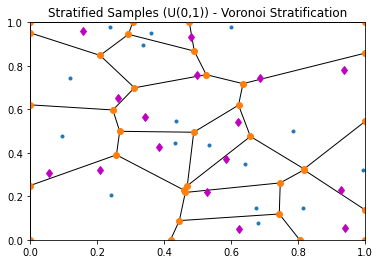

In [5]:
fig = voronoi_plot_2d(x.strata_object.voronoi)
plt.title('Stratified Samples (U(0,1)) - Voronoi Stratification')
plt.plot(x.samples[:, 0], x.samples[:, 1], 'dm')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

RunModel class is used to define an object to evaluate the model at sample points.

In [6]:
rmodel = RunModel(model_script='python_model_function.py')

This figure shows the actual function defined in python model script.

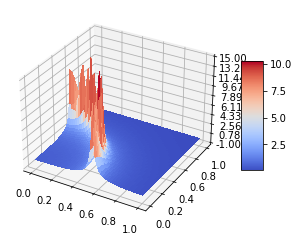

In [7]:
rmodel1 = RunModel(model_script='python_model_function.py')
rmodel1.run(samples=x.samples)

num = 50
x1 = np.linspace(0, 1, num)
x2 = np.linspace(0, 1, num)
x1v, x2v = np.meshgrid(x1, x2)
y_act = np.zeros([num, num])
r1 = RunModel(model_script='python_model_function.py')
for i in range(num):
    for j in range(num):
        r1.run(samples=np.array([[x1v[i, j], x2v[i, j]]]))
        y_act[i, j] = r1.qoi_list[-1]

fig1 = plt.figure()
ax = fig1.gca(projection='3d')
# Plot for estimated values
surf = ax.plot_surface(x1v, x2v, y_act, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-1, 15)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig1.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

Scikit-learn Gaussian Process Regrssor is used to generated a surrogate model using STS samples and function value at those points. User can also run the same example script using Kriging class from UQpy library.

In [8]:
k1 = 1.0 * Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)
K = GaussianProcessRegressor(kernel=k1, n_restarts_optimizer=5)

# K = Kriging(reg_model='Linear', corr_model='Exponential', n_opt=10, corr_model_params=[1, 1])

This figure shows the surrogate model generated using Krig class based on initial samples. Note that, user don't have to fit the surrogate model before executing RSS class, it is done here to show the 3-D plot.

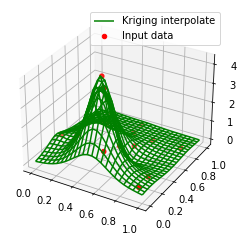

In [9]:
K.fit(x.samples, rmodel1.qoi_list)

num = 25
x1 = np.linspace(0, 1, num)
x2 = np.linspace(0, 1, num)
x1v, x2v = np.meshgrid(x1, x2)
y = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        y[i, j] = K.predict(np.array([[x1v[i, j], x2v[i, j]]]))

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
# Plot for estimated values
kr = ax2.plot_wireframe(x1v, x2v, y, color='Green', label='Kriging interpolate')

# Plot for scattered data
ID = ax2.scatter3D(x.samples[:, 0], x.samples[:, 1], rmodel1.qoi_list, color='Red', label='Input data')
plt.legend(handles=[kr, ID])
plt.show()

Using UQpy RSS class to expand samples generated by STS class. In this example, meta specifies the method used to estimate the gradient and Voronoi cells are used for stratification. Krig class is used with 'Gaussian' correlation model.

In [10]:
from UQpy.sampling import GradientEnhancedRefinement
refinement = GradientEnhancedRefinement(strata=strata, runmodel_object=rmodel, surrogate=K)

z = RefinedStratifiedSampling(stratified_sampling=x, random_state=2, refinement_algorithm = refinement)

After initiating the RSS class object, new samples are generated using the RSS.sample method.

In [11]:
z.run(nsamples=50)

This figure shows the final samples generated using RSS class, where red dots shows the initial samples.

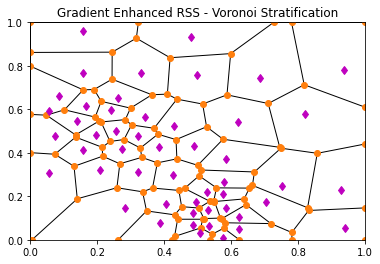

In [12]:
fig = voronoi_plot_2d(refinement.strata.voronoi)
plt.title('Gradient Enhanced RSS - Voronoi Stratification')
plt.plot(z.samplesU01[:, 0], z.samplesU01[:, 1], 'dm')
plt.ylim(0, 1)
plt.xlim(0, 1)
plt.show()

This figure shows the final surrogate model, generated using 200 samples.

<Figure size 432x288 with 0 Axes>

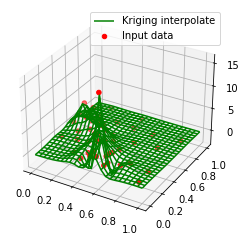

In [13]:
y = np.zeros([num, num])
for i in range(num):
    for j in range(num):
        y[i, j] = refinement.surrogate.predict(np.array([[x1v[i, j], x2v[i, j]]]))

plt.clf()
fig4 = plt.figure()
a2 = fig4.gca(projection='3d')
# Plot for estimated values
kr = a2.plot_wireframe(x1v, x2v, y, color='Green', label='Kriging interpolate')

# Plot for scattered data
ID = a2.scatter3D(z.samples[:, 0], z.samples[:, 1], refinement.runmodel_object.qoi_list, color='Red', label='Input data')
plt.legend(handles=[kr, ID])
plt.show()